# Objetivo - Fazer um comparativo do poder de compra do gás em relação ao salário mínimo de cada ano

In [1]:
import os
import re
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import urllib.request
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from glob import glob


# GLP

## Coletando dados

In [2]:
data_inicial = re.findall('[\w]{2,3}-[0-9]{4}-[0-9]{2}', 'https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/shpc/dsas/glp/glp-2004-01.csv')
data_inicial

['glp-2004-01']

In [3]:
search_split = data_inicial[0].split('-')
search_split

['glp', '2004', '01']

In [4]:
# Os dados no site do governo estão protegidos pelo front-end do site, não sendo possível realizar seu scrap com o Beautiful Soup de forma simples.
# Por isso, decidi fazer o scrap dos dados aproveitando-me da estrutura padronizada da URL de download, que até 2020 alterava apenas o tipo de combustível, ano e semestre.



In [5]:
def getting_data(link):
  search = re.findall('[a-zA-Z]{3}-[0-9]{4}-[0-9]{2}', link)
  search_splited = search[0].split('-')
  tipo_comb, ano, sem = search_splited[0], int(search_splited[1]), search_splited[2]


  while ano < 2021:
    url = f'https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/shpc/dsas/glp/{tipo_comb}-{ano}-{sem}.csv'
    urllib.request.urlretrieve(url, f'{tipo_comb}-{ano}-{sem}.csv')

    if sem == '02':
      ano += 1
      sem = '01'
    
    else:
      sem = '02'


In [6]:
getting_data('https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/shpc/dsas/glp/glp-2020-02.csv')

________

## Criando um DataFrame

In [2]:
# Para criar um único dataframe com todos os dados recolhidos, criamos uma lista com o glob() que nos retorna o caminho dos arquivos.

In [3]:
path = r'C:\dados\GasHistorica\Data'

all_files = glob(os.path.join(path, "*.csv"))

In [4]:
# Com isso, lemos cada um dos caminhos do csv e passamos para o concat, unindo todos os DF's em um único.

In [5]:
gas_dataframe = pd.concat((pd.read_csv(file,sep=';') for file in all_files))

C:\Users\peyq\AppData\Local\Temp\ipykernel_2540\933538887.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  gas_dataframe = pd.concat((pd.read_csv(file,sep=';') for file in all_files))


In [6]:
# No index atual, temos vários números repetidos, pois os números se repetem a cada tabela. 
# Para consertar isso, iremos resetar o index, atribuindo assim uma única posição a cada elemento,
# e dropando a coluna para que ela não continue no DF.

In [7]:
gas_dataframe = gas_dataframe.reset_index(drop=True)

## Limpeza e tratamento dos dados do Gás

In [8]:
gas_dataframe.columns

Index(['Regiao - Sigla', 'Estado - Sigla', 'Municipio', 'Revenda',
       'CNPJ da Revenda', 'Nome da Rua', 'Numero Rua', 'Complemento', 'Bairro',
       'Cep', 'Produto', 'Data da Coleta', 'Valor de Venda', 'Valor de Compra',
       'Unidade de Medida', 'Bandeira'],
      dtype='object')

In [9]:
# Após identificar as colunas, substituo as colunas relevantes que contém algum caractere que possa atrapalhar na manipulação dos dados.
# Os espaços são substituidos por _ , acentuações removidas (se existirem), além da padronização para letras minúsculas.

In [10]:
gas_dataframe = gas_dataframe.rename({'Data da Coleta': 'data',
                            'Estado - Sigla': 'estado',
                            'Regiao - Sigla':'regiao',
                            'Valor de Venda':'valor_venda',
                            'Valor de Compra':'valor_compra',
                            'Revenda':'revenda',
                            'CNPJ da Revenda':'cnpj_revenda',
                            'Nome da Rua':'nome_rua',}, axis=1)

In [11]:
gas_dataframe['Unidade de Medida'].value_counts() # Verificação se a unidade de medida varia.

R$ / 13 kg    5435881
Name: Unidade de Medida, dtype: int64

In [12]:
# Transformando a data de coleta em um DateTime para facilitar possíveis operações.

In [13]:
gas_dataframe['data'] = pd.to_datetime(gas_dataframe['data'], format='%d/%m/%Y') 

In [14]:
# Corrigindo a coluna de valor de venda, que acusava tipos diferentes (int + str), por conta da padronização decimal brasileira.
# Aqui, substituo a "," por "." nas strs e em seguida transformo todos os valores em float, padronizando-os.

gas_dataframe['valor_venda'] = pd.to_numeric(gas_dataframe['valor_venda'].apply(lambda x: x.replace(',', '.')))

In [15]:
gas_dataframe.head(2)

,regiao,estado,Municipio,revenda,cnpj_revenda,nome_rua,Numero Rua,Complemento,Bairro,Cep,Produto,data,valor_venda,valor_compra,Unidade de Medida,Bandeira
0,SE,SP,SAO PAULO,COMPANHIA ULTRAGAZ S A,61.602.199/0240-54,RUA VICTÓRIO PRIMON,585,NaN,LIMÃO,02550-050,GLP,2004-05-11,29.8,NaN,R$ / 13 kg,BRANCA
1,SE,SP,AMERICANA,COMPANHIA ULTRAGAZ S A,61.602.199/0264-21,RUA ORLANDO DEI SANTI,1286,NaN,JD. AMERICA,13477-000,GLP,2004-05-11,30.0,NaN,R$ / 13 kg,BRANCA


In [16]:
# Com isso, nossa limpeza inicial está completa. Caso veja a necessidade durante o decorrer da análise, adicionarei os próximos passos da limpeza abaixo.

____________

# Salário Mínimo

In [17]:
url_sm = 'http://www.ipeadata.gov.br/exibeserie.aspx?stub=1&serid1739471028=1739471028'

In [18]:
# Os dados do salário mínimo estão disponíveis no site do IPEA de forma mais simplificada do que no portal de dados do governo (devido ao JavaScript usado no portal),
# então coletar esses dados pode ser realizado de forma muito mais simples, usando apenas o método get e lendo o conteúdo da página. Ali, identificamos a tabela que precisamos:

In [19]:
pag_html = requests.get(url_sm)
df_list = pd.read_html(pag_html.text)

In [20]:
df_list[2]

,0,1
0,Data,Salário mínimo vigente
1,1940.07,87273E-14
2,1940.08,87273E-14
3,1940.09,87273E-14
4,1940.10,87273E-14
...,...,...
986,2022.08,"1.212,00"
987,2022.09,"1.212,00"
988,2022.10,"1.212,00"
989,2022.11,"1.212,00"


In [21]:
# Atribuindo os headers das colunas em seus devidos lugares

In [22]:
salario_geral = df_list[2].rename(columns=df_list[2].iloc[0]).drop(0)
salario_geral.head()

,Data,Salário mínimo vigente
1,1940.07,87273E-14
2,1940.08,87273E-14
3,1940.09,87273E-14
4,1940.10,87273E-14
5,1940.11,87273E-14


In [23]:
# Prosseguimos com a limpeza, alterando a data para o formato correto e atribuindo o resultado como index.
# Aproveito também para trocar o nome da coluna salário, de forma que a acentuação e espaços não atrapalhem nas consultas.

In [24]:
salario_geral['Data'] = pd.to_datetime(salario_geral['Data'], format='%Y/%m')
salario_geral = salario_geral.set_index('Data')
salario_geral = salario_geral.rename({'Salário mínimo vigente':'Salario'},axis=1)


In [25]:
# Aqui, faço um slice no salário usando como data de inicio o mês que obtemos a primeira média de preços com os registros do gás (Feito mais abaixo, na seção _________).
# Além disso, os números estão despadronizados, alguns com 0's a mais, os últimos que chegam aos milhares contam com . e , na mesma string
# Então, aproveito para tratar e remover os centavos 0's a mais, transformando-o para int.

In [26]:
salario_selecionado = salario_geral.loc['2004-06':'2020'].copy()
salario_selecionado['Salario'] = (salario_selecionado.Salario.apply(lambda x: x[:-2].replace((','), '')))
salario_selecionado['Salario'] = pd.to_numeric(salario_selecionado.Salario.apply(lambda x: x.replace('.', '')))

In [27]:
salario_selecionado.Salario

Data
2004-06-01     260
2004-07-01     260
2004-08-01     260
2004-09-01     260
2004-10-01     260
              ... 
2020-08-01    1045
2020-09-01    1045
2020-10-01    1045
2020-11-01    1045
2020-12-01    1045
Name: Salario, Length: 199, dtype: int64

In [28]:
#
# Ideia: Plotar por cima do grafico abaixo um segundo com marcadores nos momentos que ocorre aumento salarial (coluna separada identificando? outro dataset?)
# Cuidado: Poluição visual. Talvez seja necessário remover o grid

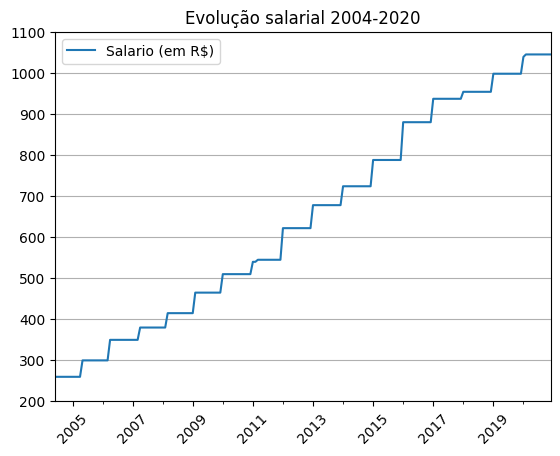

In [29]:
salario_selecionado.plot(kind='line', ylim=(200,1100))
plt.title('Evolução salarial 2004-2020')
plt.grid(which='major', axis='y')

plt.xlabel('')
plt.xticks(rotation=45)

plt.legend(['Salario (em R$)'])
plt.show()

In [30]:
# Podemos observar que o crescimento de salários ocorre de maneira irregular ao longo dos anos, variando até mesmo o intervalo de tempo em que é aumentado.
# Um claro exemplo disso ocorre entre 2010 e 2011, onde o salário é aumentado duas vezes em um intervalo de 4 meses (Em Janeiro e março ocorrem aumentos),
# para se estabilizar novamente até o final daquele ano.

In [31]:
salario_selecionado['2010-11':'2011-03']

,Salario
Data,
2010-11-01,510
2010-12-01,510
2011-01-01,540
2011-02-01,540
2011-03-01,545


_________

# GLP: Unificando as diversas coletas para uma frequência mensal

In [32]:
gas_dataframe.head()

,regiao,estado,Municipio,revenda,cnpj_revenda,nome_rua,Numero Rua,Complemento,Bairro,Cep,Produto,data,valor_venda,valor_compra,Unidade de Medida,Bandeira
0,SE,SP,SAO PAULO,COMPANHIA ULTRAGAZ S A,61.602.199/0240-54,RUA VICTÓRIO PRIMON,585,NaN,LIMÃO,02550-050,GLP,2004-05-11,29.8,NaN,R$ / 13 kg,BRANCA
1,SE,SP,AMERICANA,COMPANHIA ULTRAGAZ S A,61.602.199/0264-21,RUA ORLANDO DEI SANTI,1286,NaN,JD. AMERICA,13477-000,GLP,2004-05-11,30.0,NaN,R$ / 13 kg,BRANCA
2,SE,MG,IBIRITE,COPAGAZ DISTRIBUIDORA DE GÁS S/A.,03.237.583/0057-11,ESTRADA DO PETROVALE,50,A,PETROVALE,32400-000,GLP,2004-05-11,28.0,"23,5",R$ / 13 kg,BRANCA
3,NE,PB,CABEDELO,NACIONAL GAS BUTANO DISTRIBUIDORA LTDA,06.980.064/0006-97,RUA PREFEITO ENIVALDO FIGUEIREDO MIRANDA,93,NaN,CENTRO,58310-000,GLP,2004-05-10,35.0,NaN,R$ / 13 kg,BRANCA
4,N,PA,MARABA,PARAGAS DISTRIBUIDORA LTDA.,05.840.319/0017-06,"ROD. TRANSAMAZONICA,",1,"KM 02, ESTRADA DO SORORO",CIDADE NOVA,68501-660,GLP,2004-05-10,31.9,NaN,R$ / 13 kg,BRANCA


In [33]:
valor_glp_meses = gas_dataframe.resample("M", on='data').mean().reset_index()
valor_glp_meses

,data,valor_venda
0,2004-05-31,30.333714
1,2004-06-30,30.298823
2,2004-07-31,30.330043
3,2004-08-31,30.224504
4,2004-09-30,30.106575
...,...,...
195,2020-08-31,71.045171
196,2020-09-30,NaN
197,2020-10-31,74.971385
198,2020-11-30,75.240802


In [34]:
# Percebemos a falta de um valor (NaN). O ano de 2020 nesse conjunto de dados apresenta um número muito menor de registros, e o mês de setembro inteiro (09)
# não teve registros. Podemos observar isso fazendo uma query no dataframe geral, que não nos retorna nenhum resultado:

In [35]:
gas_dataframe[(gas_dataframe.data.dt.month == 9) & (gas_dataframe.data.dt.year == 2020)]

,regiao,estado,Municipio,revenda,cnpj_revenda,nome_rua,Numero Rua,Complemento,Bairro,Cep,Produto,data,valor_venda,valor_compra,Unidade de Medida,Bandeira


In [36]:
# Para contornar o problema, preencheremos o valor de acordo com os que estão próximos a ele:

In [37]:
valor_glp_meses = valor_glp_meses.fillna(method='bfill')

valor_glp_meses[valor_glp_meses.valor_venda.notna() == False] # Mostrando que não temos mais valores nulos

,data,valor_venda


In [38]:
# Agora que reduzimos nosso conjunto à média mensal do gás, podemos relacionar isso com os valores mensais do salário mínimo.

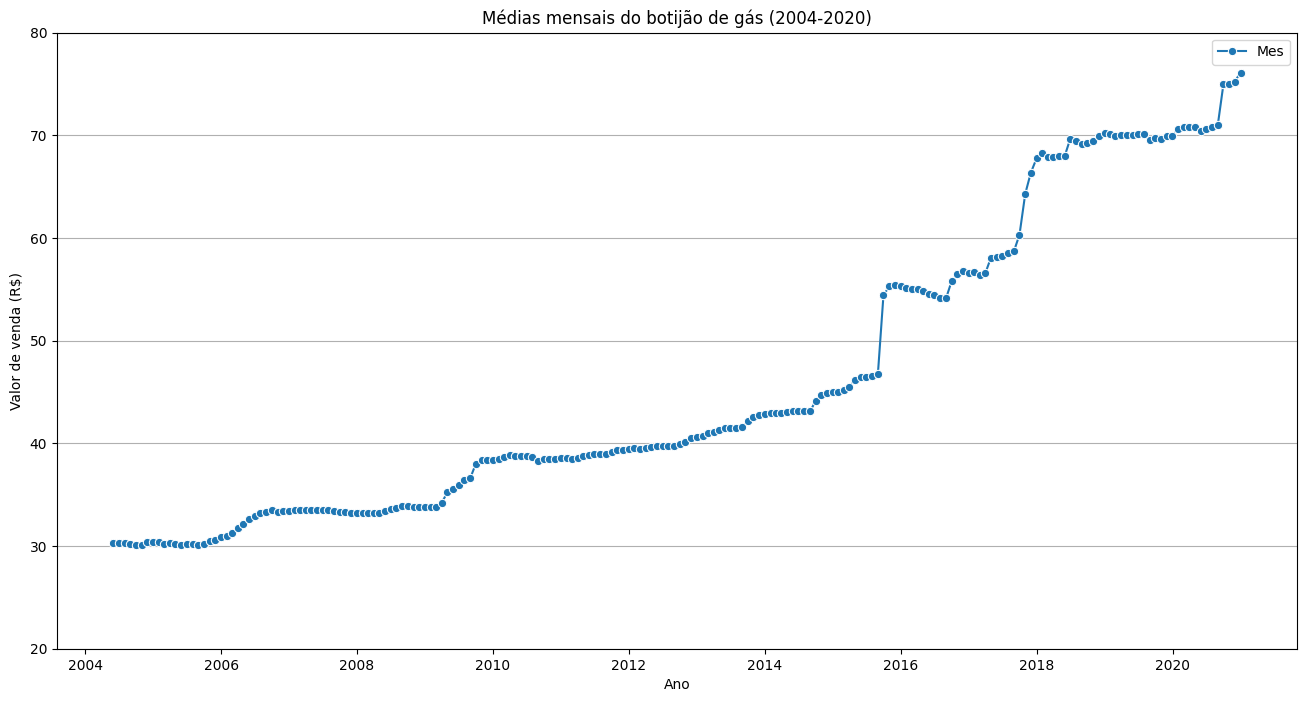

In [39]:
# Plotando a média do valor de venda em todo o território nacional no período de 2004 a 2020.

ax = plt.subplots(figsize=(16,8))
plt.title('Médias mensais do botijão de gás (2004-2020)')
plt.xlabel('Ano')
plt.ylabel('Valor de venda (R$)')
plt.grid(axis='y')
plt.ylim((20, 80))
sns.lineplot(valor_glp_meses, x='data', y='valor_venda', marker='o', label='Mes')
plt.show()

In [40]:
# Podemos observar dois momentos de aumento brusco: Entre 2015 e 2016 e entre 2018 e 2019. 

# Pesquisar as possíveis causas.

_________

# Utilizando ambos datasets

_______

# Anotações: 

To_Do: Pesquisar e usar o selenium para interagir com o JS da página de dados do gov e coletar através dele.

______

Verificar o preço em relação à inflação desde 2004

Verificar a quantidade de registros em cada um dos anos (2020 tem muitos registros faltantes). Observar a tendência ao longo dos anos.